In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib notebook

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\begin{split}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1]).
	\end{split}
	\label{poisson2d:laplace}
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [3]:
def prob5(n):
    """Let I be the n × n identity matrix, and define
                    [B I        ]        [-4  1            ]
                    [I B I      ]        [ 1 -4  1         ]
                A = [  I . .    ]    B = [    1  .  .      ],
                    [      . . I]        [          .  .  1]
                    [        I B]        [             1 -4]
    where A is (n**2,n**2) and each block B is (n,n).
    Construct and returns A as a sparse matrix.

    Parameters:
        n (int): Dimensions of the sparse matrix B.

    Returns:
        A ((n**2,n**2) SciPy sparse matrix)
    """
    offsets = [-1, 0, 1]
    #start by creating the B matrix using spars.diags
    B = sp.diags([1,-4,1], offsets, shape=(n,n)).toarray()
    #also we will need the identiy size nxn
    I = np.eye(n)
    #put B and I in coordinate format so they can be used with sparse.bmat later
    I = sp.coo_matrix(np.eye(n))
    B = sp.coo_matrix(B)
    #initialize a big_list to fill with our matrix blocks, and none/temp_lists
    #to create each row needed for our final matrix A and add them to big_list
    #as we go
    big_list = []
    temp_list = []
    none_list = []
    #fill non_list with n None values (used to create zero blocks with sparse.bmat)
    for i in range(n):
        none_list.append(None)
    #fill first row with [B,I,None,....,None]
    temp_list[0:2] = [B, I]
    temp_list[2:n] = none_list[2:n]
    #Add the first row to big_list
    big_list.append(temp_list[:])
    for i in range(1, n-1):
        #shifts the I,B,I to the right 1 each iteration and fills in the sides
        #of the row with None values, stops before the last desired row
        temp_list[0:i-1] = none_list[0:i-1]
        temp_list[i-1:i+2] = [I, B, I]
        temp_list[i+2:n] = none_list[i+2:n]
        #add all the middle rows one by one
        big_list.append(temp_list[:])
    #fill the last row with [None,None,...,I,B]
    temp_list[0:n-2] = none_list[0:n-2]
    temp_list[n-2:n] = [I, B]
    #add the last row to big_list
    big_list.append(temp_list[:])
    #finally use the big_list template to create a giant block array with sparse.bmat
    A = sp.bmat(big_list, format='csr')
    return A

In [17]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    # Set up A matrix in equation AU + p + q = f (13.4)
    h = (b-a)/n
    A = (1/h**2) * prob5(n-1)
    
    # Set up p vector
    p = np.zeros(n-1)
    p[0] = g(a, c+h)
    p[-1] = g(b, c+h)
    p = (1/h**2) * p
    
    for i in range(2, n):
        temp = np.zeros(n-1)
        temp[0] = g(a, c+i*h)
        temp[-1] = g(b, c+i*h)
        temp = (1/h**2) * temp
        p = np.concatenate((p, temp))
    
    # Set up q vector
    q = np.zeros((n-1) * (n-1))
    q[:n-1] = (1/h**2) * np.array([g(a+i*h, c) for i in range(1, n)])
    q[len(q) - (n-1) :] = (1/h**2) * np.array([g(a+i*h, d) for i in range(1, n)])
    
#     f = np.array([f(a+i*h,c+j*h) for i in range(1, n) for j in range(1, n)])
    # Set up f vector using a meshgrid
    x,y = np.linspace(a,b,n+1),np.linspace(c,d,n+1)
    X,Y = np.meshgrid(x,y)
    
    f = f(X[1:-1,1:-1], Y[1:-1,1:-1]).flatten()
    
    # Solve equation AU = f - p - q for U
    return spla.spsolve(A, f - p - q)

(99, 99) (99, 99) (99, 99)


<IPython.core.display.Javascript object>


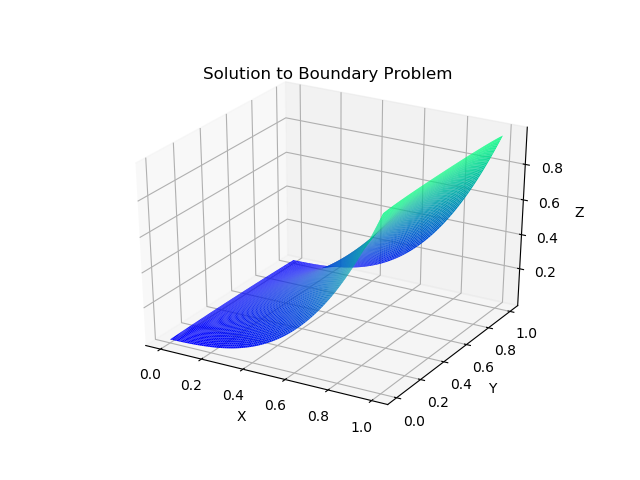

Text(0.5, 0, 'Z')

In [11]:
# Set up intital value problem conditions
g = lambda x,y: x**3
f = lambda x,y: 0
f = np.vectorize(f)
n = 100

# Solve initial value problem 
U = poisson_square(0,1,0,1,f,g,n)
# Solution is a matrix in vector form, reshape back into matrix form
Z = U.reshape((n-1,n-1))

# Plot solution
x = np.linspace(0, 1, 99)
y = np.linspace(0, 1, 99)
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title("Solution to Boundary Problem")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Problem 2

Solve 

\begin{align}
	\begin{split}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
	\end{split}
	\label{poisson2d:source}
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

<IPython.core.display.Javascript object>


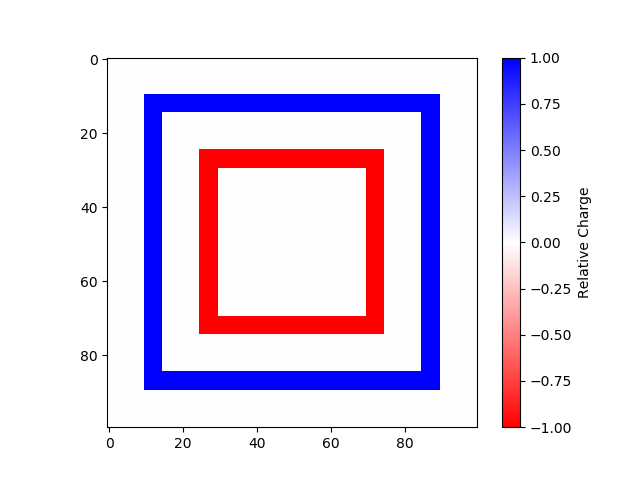

In [12]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

fig = plt.figure()
plt.imshow(source(X,Y),cmap = mcolors.LinearSegmentedColormap('cmap', genDict(source(X,Y))))
plt.colorbar(label="Relative Charge")
plt.show()

<IPython.core.display.Javascript object>


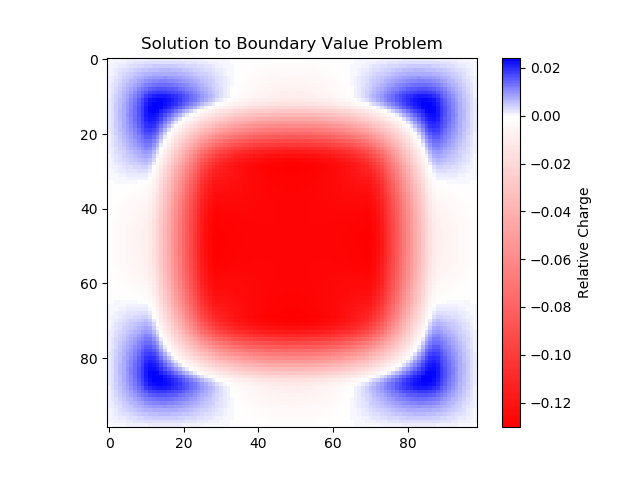

In [19]:
# Set up conditions for inital value problem
f = lambda x, y: -source(x,y)
g = lambda x, y: 0
X = np.linspace(a1,b1,n-1)
Y = np.linspace(c1,d1,n-1)
X,Y = np.meshgrid(X,Y)

# Approximate solution
U = poisson_square(a1,b1,c1,d1,f,g,n)
# Reshape solution back into a matrix form
Z = U.reshape((n-1,n-1))

# Plot solution
fig = plt.figure()
plt.imshow(Z,cmap = mcolors.LinearSegmentedColormap('cmap', genDict(Z)))
plt.colorbar(label="Relative Charge")
plt.title("Solution to Boundary Value Problem")
plt.show()